In [1]:
from PIL import Image, ImageDraw, ImageFont
import numpy as np
from scipy import linalg
from IPython.display import display
from scipy.stats import ortho_group
import matplotlib.pyplot as plt

In [2]:
!apt-get -y install fonts-ipafont-gothic

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-ipafont-gothic is already the newest version (00303-18ubuntu1).
0 upgraded, 0 newly installed, 0 to remove and 15 not upgraded.


In [3]:
fpath='/usr/share/fonts/opentype/ipafont-gothic/ipagp.ttf'
fontsize = 50
font = ImageFont.truetype(fpath, fontsize)

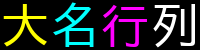

In [4]:
W = 200
H = fontsize
img  = Image.new('RGB', (W,H),color="black")
draw = ImageDraw.Draw(img)
draw.text((0,0), "大　　　", fill=(255,255,0), font=font)
draw.text((0,0), "　名　　", fill=(0,255,255), font=font)
draw.text((0,0), "　　行　", fill=(255,0,255), font=font)
draw.text((0,0), "　　　列", fill="white", font=font)
img

In [5]:
data = np.array(img.getdata()).reshape(H,W,3)

In [6]:
def restore(L, C, R):
  LC = np.tensordot(L,C,(1,0))
  Y = np.tensordot(LC, R, (2,0))
  Y = Y.transpose((0,2,1))
  return Y

In [7]:
def restore_image(U, C, V):
  UC = np.tensordot(U,C,(1,0))
  Y = np.tensordot(UC, V, (2,0))
  Y = Y.transpose((0,2,1))
  Y = np.clip(Y, 0, 255)
  Y = np.uint8(Y)
  return Image.fromarray(Y)

In [8]:
def tucker_hosvd(X, rank):
  X = X.transpose(0,2,1)
  XR = X.reshape(H*3, W)
  _, _, V = linalg.svd(XR)
  V = V[:rank,:]
  Vt = V.transpose(1,0)
  XL = X.reshape(H, W*3)
  U, _, _ = linalg.svd(XL)
  U = U[:,:rank]
  Ut = U.transpose(1,0)
  # Make a core tensor
  UX = np.tensordot(Ut, X, (1,0))
  C = np.tensordot(UX, Vt, (2, 0))
  return U, C, V

In [9]:
def residual(X, L, R):
  X = X.transpose(0,2,1)
  LX = np.tensordot(L.transpose(), X, (1,0))
  C = np.tensordot(LX, R.transpose(), (2,0))
  Y = restore(U, C, V)
  return np.square(X-Y).sum() / np.square(X).sum()

In [10]:
def tucker_hooi(X, r):
  L = ortho_group.rvs(H)[:, :r]
  R = ortho_group.rvs(W)[:r, :]
  X = X.transpose(0,2,1)
  for i in range(20):
    LX = np.tensordot(L.transpose(), X, (1,0)).reshape(r*3, W)
    U,s,V = linalg.svd(LX)
    R = V[:r, :]
    XR = np.tensordot(X, R.transpose(), (2,0)).reshape(H, 3*r)
    U,s,V = linalg.svd(XR)
    L = U[:, :r]
  LX = np.tensordot(L.transpose(), X, (1,0))
  C = np.tensordot(LX, R.transpose(), (2,0))
  return L, C, R

In [11]:
def residual(X, U, C, V):
  Y = restore(U, C, V)
  return np.square(X-Y).sum() / np.square(X).sum()

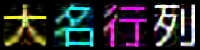

In [12]:
L, C, R = tucker_hosvd(data, 10)
restore_image(L, C, R)

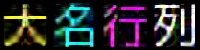

In [13]:
L, C, R = tucker_hooi(data, 10)
restore_image(L, C, R)

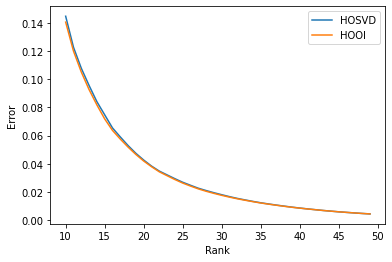

In [14]:
fig, ax = plt.subplots()
r_hosvd = []
r_hooi = []
D = 10
for r in range(D,H):
  U, C, V = tucker_hosvd(data, r)
  r_hosvd.append(residual(data, U, C, V))
  U, C, V = tucker_hooi(data, r)
  r_hooi.append(residual(data, U, C, V))

x = list(range(D, H))
ax.set_xlabel('Rank')
ax.set_ylabel('Error')
ax.plot(x, r_hosvd,label="HOSVD")
ax.plot(x, r_hooi, label="HOOI")
ax.legend(loc=0)

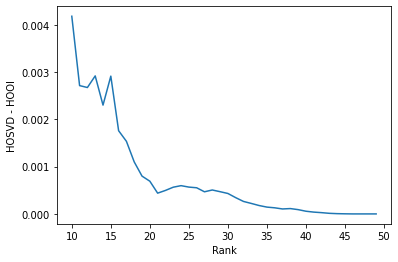

In [15]:
diff = np.array(r_hosvd) - np.array(r_hooi)
fig, ax = plt.subplots()
ax.set_xlabel('Rank')
ax.set_ylabel('HOSVD - HOOI')
plt.plot(x, diff)